<div class="list-group" id="list-tab" role="tablist">
  <h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home">Housing Prices Regression</h3>
<div class="list-group" id="list-tab" role="tablist">
  <h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home">Table of Contents</h3>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#data" role="tab" aria-controls="profile">Fetch the data<span class="badge badge-primary badge-pill">1</span></a>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#down" role="tab" aria-controls="settings">Exploratory Data Analysis<span class="badge badge-primary badge-pill">2</span></a> 
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#fe" role="tab" aria-controls="settings">Feature Engineering<span class="badge badge-primary badge-pill">3</span></a>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#pred" role="tab" aria-controls="settings">Modelling and Prediction<span class="badge badge-primary badge-pill">4</span></a>

# <a id='data'>1. Fetch the data</a> 

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import category_encoders as ce
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.tree import DecisionTreeRegressor
from sklearn.inspection import permutation_importance

from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import warnings; warnings.simplefilter('ignore')
import statsmodels.api as sm 
import gc
import re


train =  pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# <a id='down'>2. EDA</a>  

Exploratory data analysis is done in Tableau

# <a id='fe'>3. Feature Engineering</a>   

In [2]:
def Encoding(dataframe, ordinal_ratings, nominal):
    df= dataframe.copy()   
    
    for i in ordinal_ratings:
        encoder= ce.OrdinalEncoder(cols=[str(i)], return_df=True, mapping=[{'col':str(i), 'mapping':{'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}}])
        df[str(i)]= encoder.fit_transform(df[str(i)])
                
    for i in nominal:
        encoder=ce.OneHotEncoder(cols=str(i),handle_unknown='return_nan',return_df=True,use_cat_names=True)
        con= encoder.fit_transform(df[str(i)])
        df= pd.concat([df,con], axis=1)
        
#     for i in ordinal:
#         encoder= ce.OrdinalEncoder(cols=[str(i)], return_df=True)
#         df[str(i)]= encoder.fit_transform(df[str(i)])
    
    df = df.drop(nominal, axis = 1) 
    gc.collect()
    return df 


 Creating Training DataFrame

In [3]:
selected_columns= train[['SalePrice','ExterQual','MSSubClass','LotFrontage','BedroomAbvGr', 
                         '1stFlrSF','OverallCond','OverallQual','KitchenQual','BsmtCond','HeatingQC',
                         'CentralAir','YearBuilt','YearRemodAdd','LotArea', 'LotShape','LandContour','BldgType']]

df_train = selected_columns.copy()
ordinal_ratings = [ 'BsmtCond' ,'HeatingQC','KitchenQual','ExterQual']
nominal = [ 'CentralAir','BldgType' ,'LotShape','LandContour']
df_train = Encoding(df_train,ordinal_ratings,nominal)
df_train['LotFrontage']=df_train['LotFrontage'].fillna(df_train['LotFrontage'].mean())
X = df_train.drop('SalePrice' , axis=1)
Y = df_train['SalePrice']


selected_columns= test[['ExterQual','MSSubClass','LotFrontage','BedroomAbvGr', 
                         '1stFlrSF','OverallCond','OverallQual','KitchenQual','BsmtCond','HeatingQC',
                         'CentralAir','YearBuilt','YearRemodAdd','LotArea', 'LotShape','LandContour','BldgType']]
df_test = selected_columns.copy()
df_test = Encoding(df_test,ordinal_ratings,nominal)
df_test['LotFrontage']=df_train['LotFrontage'].fillna(df_train['LotFrontage'].mean())





# <a id='pred'>4. Modelling and Prediction</a> 

Implementation of shuffle split

In [4]:
algos = {
    'Linear_Regression' : {'model': LinearRegression,
                            'parameters': {'normalize': [True,False]
                                              }
                          },

                 'Lasso': {'model': Lasso,
                           'parameters': {'alpha': [0.01,0.1,0.5,1,2,5,10,20],
                                          'selection': ['random', 'cyclic']
                                         }
                          },

                 'Ridge': {'model' : Ridge, 
                            'parameters':{'alpha': [0.01,0.1,0.5,1,2,5,10,20]
                                         }
                          } ,
         
        
         'Decision_Tree': {'model': DecisionTreeRegressor, 
                            'parameters': {'criterion' : ['mse','friedman_mse','mae'],
                                           'splitter': ['best','random']
                                          }
                          }
         
         
        }

In [12]:
seed = 100
class Model():

    seed = 100 
    def __init__(self,dataframe,X,Y,algo_dictionary, problem_type):
        self.df = dataframe
        self.algos = algo_dictionary
        self.problem_type = problem_type
        self.X = X
        self.Y = Y
        self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(self.X,self.Y,test_size=0.2,random_state= self.seed)


    def Gridsearch(self,name,update_best_features = None):


        for key,value in self.algos[name].items():

            cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=self.seed)
            gs =  GridSearchCV(value['model'](), value['parameters'], cv=cv, return_train_score=False)
            gs.fit(self.X,self.Y)

            if update_best_features is True:
                value['parameters'] = gs.best_params_


        print({'model': key,'best_score': gs.best_score_,'best_parameters': gs.best_params_})


    def Gridsearch_all(self,update_best_features = None):


        table = []
        for key,value in self.algos.items():

            cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state= self.seed)
            gs =  GridSearchCV(value['model'](), value['parameters'], cv=cv, return_train_score=False)
            gs.fit(self.X,self.Y)
            table.append({'model': key,'best_score': gs.best_score_,'best_parameters': gs.best_params_})

            if update_best_features is True:
                value['parameters'] = gs.best_params_


        table = pd.DataFrame(table)
        print(table)


    def train(self,algorithm_name):


        parameters = self.algos[algorithm_name]['parameters']
        self.algos[algorithm_name]['model'] = self.algos[algorithm_name]['model'](**parameters)
        self.self.algos[algorithm_name]['model'].fit(self.X_train,self.Y_train)


        # for key,value in algos[name].items():
        # 	parameters = value['parameters']
        # 	value['model'] = value['model'](**parameters)
        # 	value['model'].fit(x_train, y_train)


        predictions = self.algos[algorithm_name]['model'].predict(self.X_test)
        if self.problem_type == 'Classification':
            print('Classification report after predicting on testing data for', algorithm_name)
            print(classification_report(self.Y_test, predictions))
            print('TN,FN')
            print('FP,TP')
            print(confusion_matrix(self.Y_test, predictions))


    def train_all(self):
        for key,value in self.algos.items():
            parameters = value['parameters']
            value['model'] = value['model'](**parameters)
            value['model'].fit(self.X_train, self.Y_train)

            predictions = value['model'].predict(self.X_test)
            if self.problem_type == 'Classification':
                print('Classification report after predicting on testing data for', key)
                print(classification_report(self.Y_test, predictions))
                print('TN,FN')
                print('FP,TP')
                print(confusion_matrix(self.Y_test, predictions))
                print('\n')

            if self.problem_type == 'Regression':
                pass


    def predict(self,x_input,algorithm_name):
        predictions = self.algos[algorithm_name]['model'].predict(x_input)
        return predictions


    def feature_importances(self,x,y):
        pass


    def permutation_importances(self,x,y):
        pass


    def remove_algo(self, name):
        del self.algos[str(name)]


    def add_algo(self,dict):
        self.algos.update(dict)


    def reset_seed(self , new_seed):
        self.seed = new_seed


    def report(self):
        if self.problem_type == 'Regression':
            pass

        elif self.problem_type == 'Classification':
            pass

        else:
            print('Please define problem_type')


In [6]:
m1 = Model(df_train,X,Y,algos,'Regression')


In [7]:
m1.Gridsearch_all()


               model  best_score                               best_params
0  Linear_Regression    0.783038                       {'normalize': True}
1              Lasso    0.783077      {'alpha': 20, 'selection': 'cyclic'}
2              Ridge    0.783695                              {'alpha': 5}
3      Decision_Tree    0.715008  {'criterion': 'mse', 'splitter': 'best'}


# Neural Networks Implementation 

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state= seed)


In [37]:
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU,PReLU,ELU
from keras.layers import Dropout
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

#Tree of NN
# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(output_dim =len(X_train.columns) , init = 'he_uniform',activation='relu',input_dim = len(X_train.columns)))

# Adding the second hidden layer
classifier.add(Dense(output_dim = 28, init = 'he_uniform',activation='relu'))
               
# Adding the output layer
classifier.add(Dense(output_dim = 1, init = 'he_uniform'))

# Compiling the ANN
classifier.compile(loss=root_mean_squared_error, optimizer='Adamax')

# Fitting the ANN to the Training set
model_history=classifier.fit(X_train.values, Y_train.values,validation_split=0.20, batch_size = 10, nb_epoch = 1000)

Train on 934 samples, validate on 234 samples
Epoch 1/1000
934/934 [==============================] - 0s 270us/step - loss: 191706.0540 - val_loss: 178426.3421
Epoch 2/1000
934/934 [==============================] - 0s 150us/step - loss: 168059.7374 - val_loss: 140052.8111
Epoch 3/1000
934/934 [==============================] - 0s 160us/step - loss: 114463.4281 - val_loss: 99004.3021
Epoch 4/1000
934/934 [==============================] - 0s 171us/step - loss: 87414.1094 - val_loss: 88012.2916
Epoch 5/1000
934/934 [==============================] - 0s 154us/step - loss: 78319.7118 - val_loss: 86961.4983
Epoch 6/1000
934/934 [==============================] - 0s 146us/step - loss: 77078.4311 - val_loss: 86653.3473
Epoch 7/1000
934/934 [==============================] - 0s 150us/step - loss: 78095.0741 - val_loss: 85621.7771
Epoch 8/1000
934/934 [==============================] - 0s 189us/step - loss: 76838.3704 - val_loss: 84203.6718
Epoch 9/1000
934/934 [==============================]

Epoch 73/1000
934/934 [==============================] - 0s 147us/step - loss: 61740.1924 - val_loss: 61076.6222
Epoch 74/1000
934/934 [==============================] - 0s 149us/step - loss: 61577.9574 - val_loss: 61053.8125
Epoch 75/1000
934/934 [==============================] - 0s 137us/step - loss: 61551.8833 - val_loss: 60879.9116
Epoch 76/1000
934/934 [==============================] - 0s 146us/step - loss: 61160.0062 - val_loss: 60993.3733
Epoch 77/1000
934/934 [==============================] - 0s 146us/step - loss: 61202.2926 - val_loss: 61061.5985
Epoch 78/1000
934/934 [==============================] - 0s 128us/step - loss: 61225.1240 - val_loss: 60802.4779
Epoch 79/1000
934/934 [==============================] - 0s 128us/step - loss: 61072.5254 - val_loss: 60905.5435
Epoch 80/1000
934/934 [==============================] - 0s 137us/step - loss: 61075.5096 - val_loss: 60630.7343
Epoch 81/1000
934/934 [==============================] - 0s 130us/step - loss: 60303.2367 - val_

934/934 [==============================] - 0s 134us/step - loss: 57745.4886 - val_loss: 58119.6407
Epoch 146/1000
934/934 [==============================] - 0s 175us/step - loss: 57387.5525 - val_loss: 58160.1176
Epoch 147/1000
934/934 [==============================] - 0s 146us/step - loss: 58062.0655 - val_loss: 58125.1355
Epoch 148/1000
934/934 [==============================] - 0s 178us/step - loss: 58100.2903 - val_loss: 58021.8431
Epoch 149/1000
934/934 [==============================] - 0s 128us/step - loss: 58125.2482 - val_loss: 58181.2153
Epoch 150/1000
934/934 [==============================] - 0s 138us/step - loss: 58169.0626 - val_loss: 58039.0796
Epoch 151/1000
934/934 [==============================] - 0s 142us/step - loss: 58300.9177 - val_loss: 58113.6178
Epoch 152/1000
934/934 [==============================] - 0s 137us/step - loss: 57757.0084 - val_loss: 57970.0644
Epoch 153/1000
934/934 [==============================] - 0s 128us/step - loss: 57409.9861 - val_loss: 

Epoch 217/1000
934/934 [==============================] - 0s 155us/step - loss: 56974.5140 - val_loss: 57341.7400
Epoch 218/1000
934/934 [==============================] - 0s 146us/step - loss: 56746.1043 - val_loss: 57212.7241
Epoch 219/1000
934/934 [==============================] - 0s 154us/step - loss: 57019.4163 - val_loss: 57219.7814
Epoch 220/1000
934/934 [==============================] - 0s 163us/step - loss: 57214.6505 - val_loss: 57351.4642
Epoch 221/1000
934/934 [==============================] - 0s 160us/step - loss: 56844.4902 - val_loss: 57224.8638
Epoch 222/1000
934/934 [==============================] - 0s 158us/step - loss: 57619.2248 - val_loss: 57291.4947
Epoch 223/1000
934/934 [==============================] - 0s 181us/step - loss: 56762.1322 - val_loss: 57755.9815
Epoch 224/1000
934/934 [==============================] - 0s 150us/step - loss: 56770.7206 - val_loss: 57202.9027
Epoch 225/1000
934/934 [==============================] - 0s 171us/step - loss: 56556.44

Epoch 360/1000
934/934 [==============================] - 0s 206us/step - loss: 55952.0094 - val_loss: 56465.6413
Epoch 361/1000
934/934 [==============================] - 0s 171us/step - loss: 56039.4249 - val_loss: 56601.9821
Epoch 362/1000
934/934 [==============================] - 0s 159us/step - loss: 55751.9580 - val_loss: 56680.3498
Epoch 363/1000
934/934 [==============================] - 0s 163us/step - loss: 56258.7523 - val_loss: 56559.5083
Epoch 364/1000
934/934 [==============================] - 0s 162us/step - loss: 55759.2232 - val_loss: 56499.5408
Epoch 365/1000
934/934 [==============================] - 0s 157us/step - loss: 56108.9784 - val_loss: 56512.3353
Epoch 366/1000
934/934 [==============================] - 0s 188us/step - loss: 56105.6334 - val_loss: 56606.8600
Epoch 367/1000
934/934 [==============================] - 0s 163us/step - loss: 55926.5390 - val_loss: 56454.7721
Epoch 368/1000
934/934 [==============================] - 0s 146us/step - loss: 55873.25

Epoch 432/1000
934/934 [==============================] - 0s 159us/step - loss: 56053.1512 - val_loss: 56171.2389
Epoch 433/1000
934/934 [==============================] - 0s 154us/step - loss: 55576.0995 - val_loss: 56038.0686
Epoch 434/1000
934/934 [==============================] - 0s 163us/step - loss: 55093.5815 - val_loss: 56138.3121
Epoch 435/1000
934/934 [==============================] - 0s 157us/step - loss: 55687.0079 - val_loss: 56071.4804
Epoch 436/1000
934/934 [==============================] - 0s 197us/step - loss: 55396.5271 - val_loss: 55998.1172
Epoch 437/1000
934/934 [==============================] - 0s 146us/step - loss: 55871.0773 - val_loss: 56170.7427
Epoch 438/1000
934/934 [==============================] - 0s 138us/step - loss: 55948.3827 - val_loss: 56306.5915
Epoch 439/1000
934/934 [==============================] - 0s 150us/step - loss: 55567.8463 - val_loss: 56129.4204
Epoch 440/1000
934/934 [==============================] - 0s 163us/step - loss: 55322.34

Epoch 504/1000
934/934 [==============================] - 0s 146us/step - loss: 54946.8496 - val_loss: 55503.4343
Epoch 505/1000
934/934 [==============================] - 0s 146us/step - loss: 55074.7549 - val_loss: 55528.7610
Epoch 506/1000
934/934 [==============================] - 0s 163us/step - loss: 55067.5507 - val_loss: 55740.2307
Epoch 507/1000
934/934 [==============================] - 0s 180us/step - loss: 54974.3307 - val_loss: 55557.2401
Epoch 508/1000
934/934 [==============================] - 0s 147us/step - loss: 55019.7085 - val_loss: 55576.2066
Epoch 509/1000
934/934 [==============================] - 0s 156us/step - loss: 54812.2180 - val_loss: 55998.7795
Epoch 510/1000
934/934 [==============================] - 0s 167us/step - loss: 54423.3266 - val_loss: 55510.8901
Epoch 511/1000
934/934 [==============================] - 0s 154us/step - loss: 54744.0296 - val_loss: 55568.9411
Epoch 512/1000
934/934 [==============================] - 0s 162us/step - loss: 54359.68

Epoch 576/1000
934/934 [==============================] - 0s 177us/step - loss: 54544.9216 - val_loss: 55353.2381
Epoch 577/1000
934/934 [==============================] - 0s 197us/step - loss: 54910.0462 - val_loss: 55253.7385
Epoch 578/1000
934/934 [==============================] - 0s 192us/step - loss: 54162.7606 - val_loss: 55152.1905
Epoch 579/1000
934/934 [==============================] - 0s 212us/step - loss: 54602.0749 - val_loss: 55326.9063
Epoch 580/1000
934/934 [==============================] - 0s 214us/step - loss: 53982.9164 - val_loss: 55234.9821
Epoch 581/1000
934/934 [==============================] - 0s 197us/step - loss: 54379.7399 - val_loss: 55053.4239
Epoch 582/1000
934/934 [==============================] - 0s 214us/step - loss: 54676.7618 - val_loss: 55049.1643
Epoch 583/1000
934/934 [==============================] - 0s 180us/step - loss: 54646.0216 - val_loss: 55029.7323
Epoch 584/1000
934/934 [==============================] - 0s 149us/step - loss: 54535.07

Epoch 648/1000
934/934 [==============================] - 0s 150us/step - loss: 54479.3337 - val_loss: 54377.0029
Epoch 649/1000
934/934 [==============================] - 0s 155us/step - loss: 54008.3778 - val_loss: 54376.8551
Epoch 650/1000
934/934 [==============================] - 0s 159us/step - loss: 53797.6227 - val_loss: 54462.5234
Epoch 651/1000
934/934 [==============================] - 0s 154us/step - loss: 54529.9379 - val_loss: 54436.6840
Epoch 652/1000
934/934 [==============================] - 0s 154us/step - loss: 53965.1901 - val_loss: 54308.7477
Epoch 653/1000
934/934 [==============================] - 0s 150us/step - loss: 53552.8791 - val_loss: 54489.5026
Epoch 654/1000
934/934 [==============================] - 0s 154us/step - loss: 53792.3901 - val_loss: 54433.0408
Epoch 655/1000
934/934 [==============================] - 0s 146us/step - loss: 53632.9893 - val_loss: 54517.5326
Epoch 656/1000
934/934 [==============================] - 0s 182us/step - loss: 54579.76

Epoch 720/1000
934/934 [==============================] - 0s 184us/step - loss: 53317.4184 - val_loss: 53631.3960
Epoch 721/1000
934/934 [==============================] - 0s 128us/step - loss: 53343.0880 - val_loss: 53500.7017
Epoch 722/1000
934/934 [==============================] - 0s 174us/step - loss: 53562.0425 - val_loss: 53573.7030
Epoch 723/1000
934/934 [==============================] - 0s 266us/step - loss: 52507.5908 - val_loss: 53518.1650
Epoch 724/1000
934/934 [==============================] - 0s 154us/step - loss: 53352.1783 - val_loss: 53710.7098
Epoch 725/1000
934/934 [==============================] - 0s 147us/step - loss: 53644.3533 - val_loss: 53815.2274
Epoch 726/1000
934/934 [==============================] - 0s 142us/step - loss: 53465.4194 - val_loss: 53619.7375
Epoch 727/1000
934/934 [==============================] - 0s 248us/step - loss: 52882.9751 - val_loss: 53547.6931
Epoch 728/1000
934/934 [==============================] - 0s 185us/step - loss: 52711.29

Epoch 792/1000
934/934 [==============================] - 0s 146us/step - loss: 51786.9668 - val_loss: 52591.0589
Epoch 793/1000
934/934 [==============================] - 0s 146us/step - loss: 51675.8210 - val_loss: 52542.3180
Epoch 794/1000
934/934 [==============================] - 0s 150us/step - loss: 51951.3813 - val_loss: 52386.4745
Epoch 795/1000
934/934 [==============================] - 0s 146us/step - loss: 52331.6550 - val_loss: 52881.8940
Epoch 796/1000
934/934 [==============================] - 0s 163us/step - loss: 51296.4473 - val_loss: 52413.7594
Epoch 797/1000
934/934 [==============================] - 0s 152us/step - loss: 52273.3596 - val_loss: 52224.9333
Epoch 798/1000
934/934 [==============================] - 0s 214us/step - loss: 52151.6512 - val_loss: 52248.3063
Epoch 799/1000
934/934 [==============================] - 0s 146us/step - loss: 51756.7256 - val_loss: 52319.6121
Epoch 800/1000
934/934 [==============================] - 0s 154us/step - loss: 51516.87

Epoch 864/1000
934/934 [==============================] - 0s 150us/step - loss: 50185.5722 - val_loss: 50607.3944
Epoch 865/1000
934/934 [==============================] - 0s 186us/step - loss: 51135.4398 - val_loss: 50773.3272
Epoch 866/1000
934/934 [==============================] - 0s 278us/step - loss: 50086.5486 - val_loss: 50796.2173
Epoch 867/1000
934/934 [==============================] - 0s 133us/step - loss: 50419.3994 - val_loss: 51152.4922
Epoch 868/1000
934/934 [==============================] - 0s 154us/step - loss: 50302.4941 - val_loss: 50737.5261
Epoch 869/1000
934/934 [==============================] - 0s 154us/step - loss: 50001.1558 - val_loss: 50675.8791
Epoch 870/1000
934/934 [==============================] - 0s 146us/step - loss: 50176.0886 - val_loss: 50713.1234
Epoch 871/1000
934/934 [==============================] - 0s 154us/step - loss: 50407.0630 - val_loss: 50598.5731
Epoch 872/1000
934/934 [==============================] - 0s 153us/step - loss: 50177.84

Epoch 936/1000
934/934 [==============================] - 0s 139us/step - loss: 47129.5252 - val_loss: 48308.8793
Epoch 937/1000
934/934 [==============================] - 0s 142us/step - loss: 47765.4155 - val_loss: 48701.8848
Epoch 938/1000
934/934 [==============================] - 0s 137us/step - loss: 47498.7196 - val_loss: 48460.4219
Epoch 939/1000
934/934 [==============================] - 0s 163us/step - loss: 47347.4494 - val_loss: 48273.2498
Epoch 940/1000
934/934 [==============================] - 0s 146us/step - loss: 48002.5412 - val_loss: 48133.4631
Epoch 941/1000
934/934 [==============================] - 0s 128us/step - loss: 46905.9871 - val_loss: 48521.6659
Epoch 942/1000
934/934 [==============================] - 0s 151us/step - loss: 47810.1913 - val_loss: 48447.7738
Epoch 943/1000
934/934 [==============================] - 0s 142us/step - loss: 46887.3486 - val_loss: 48274.2624
Epoch 944/1000
934/934 [==============================] - 0s 153us/step - loss: 46903.51

In [42]:
classifier.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 28)                812       
_________________________________________________________________
dense_6 (Dense)              (None, 28)                812       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 29        
Total params: 1,653
Trainable params: 1,653
Non-trainable params: 0
_________________________________________________________________


In [241]:
ann_pred=classifier.predict(df_test.values)

In [242]:
pred=pd.DataFrame(ann_pred)
sub_df=pd.read_csv('sample_submission.csv')
datasets=pd.concat([sub_df['Id'],pred],axis=1)
datasets.columns=['Id','SalePrice']
datasets.to_csv('sample_submission.csv',index=False)

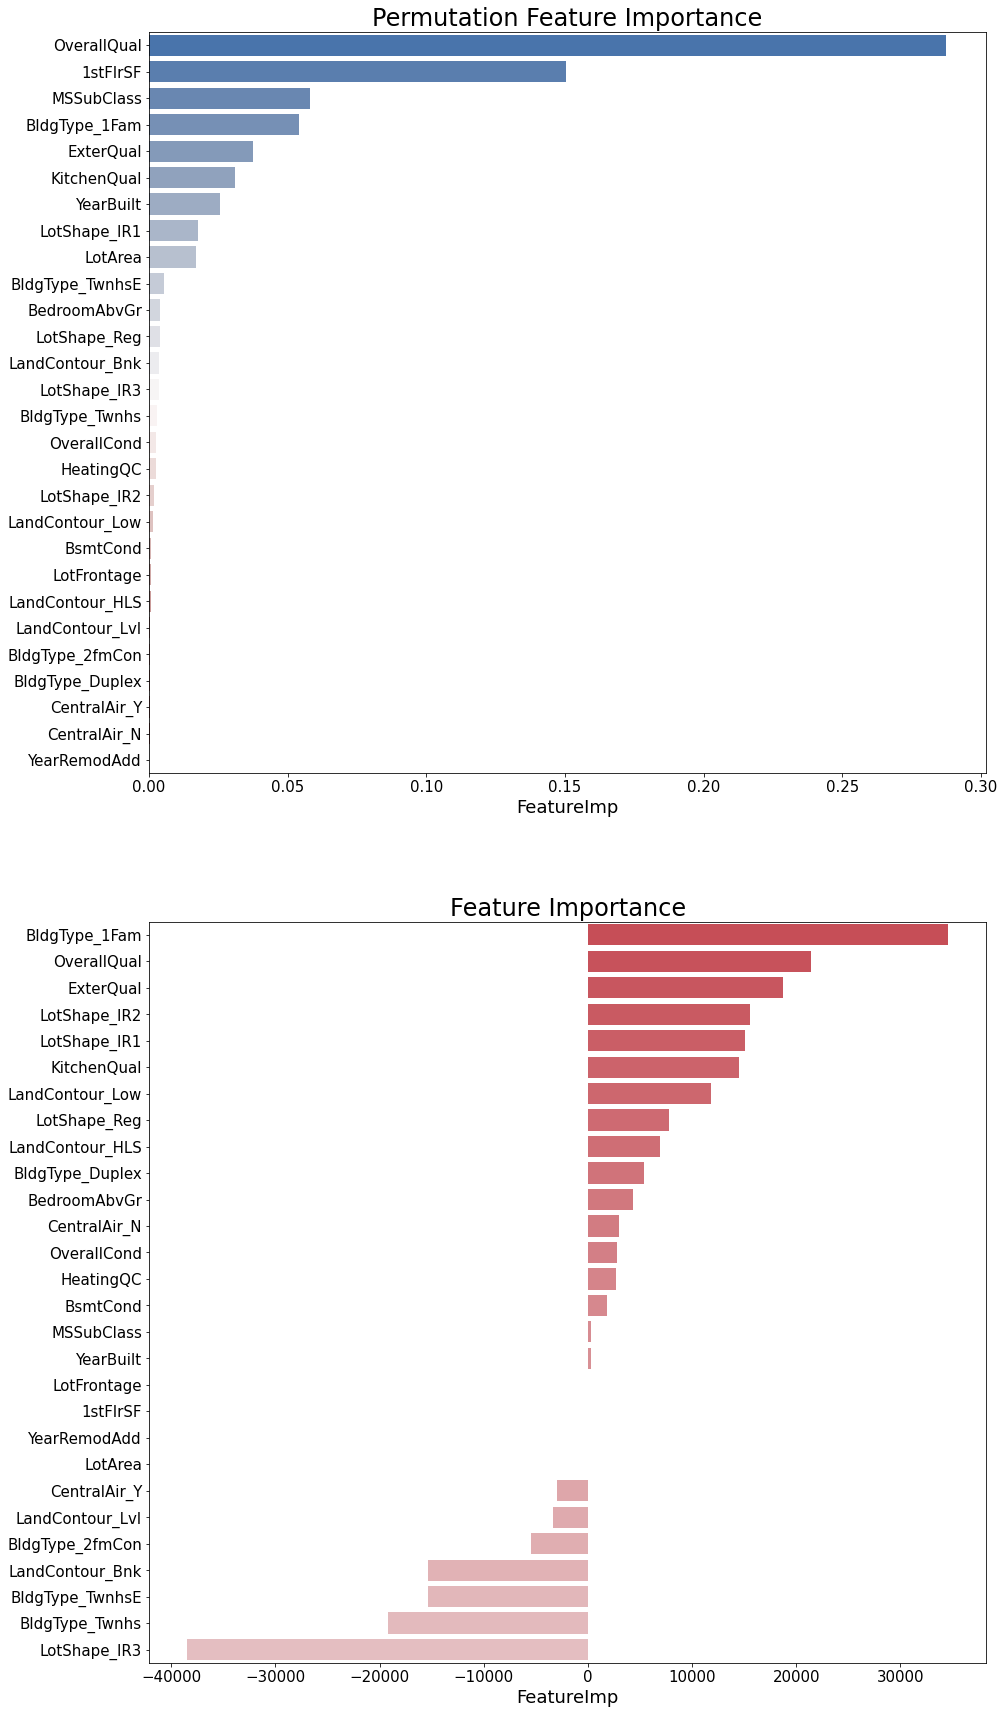

In [11]:
model = LinearRegression()
model.fit(X_train,Y_train)

sns.set_context(rc={'xtick.labelsize': 15, 
                'ytick.labelsize': 15,
                'axes.labelsize' : 18, 
                'axes.titlesize' : 24})

feature_imp = permutation_importance(model, X_train, Y_train, n_repeats=10, n_jobs=-1, random_state=50)

perm_ft_imp_df = pd.DataFrame(data=feature_imp.importances_mean,columns=['FeatureImp'], index=X_train.columns).sort_values(by='FeatureImp', ascending=False)
model_ft_imp_df = pd.DataFrame(data=model.coef_,columns=['FeatureImp'], index=X_train.columns).sort_values(by='FeatureImp', ascending=False)

fig,ax = plt.subplots(2,1, figsize=(15,30))

perm_ft_imp_df_nonzero = perm_ft_imp_df[perm_ft_imp_df['FeatureImp']!=0]
model_ft_imp_df_nonzero = model_ft_imp_df[model_ft_imp_df['FeatureImp'] !=0]

sns.barplot(x=perm_ft_imp_df_nonzero['FeatureImp'], y=perm_ft_imp_df_nonzero.index, ax=ax[0], palette="vlag")
sns.barplot(x=model_ft_imp_df_nonzero['FeatureImp'], y=model_ft_imp_df_nonzero.index, ax=ax[1], palette=sns.diverging_palette(10, 220, sep=2, n=80))


ax[0].set_title('Permutation Feature Importance')
ax[1].set_title('Feature Importance')

plt.show()